# Emprical backtest of different Asset Allocation models

### Table of contents:

0. Setup
0. Buy & Hold
1. Mean-Variance Optimization - Markowitz (1952)
2. Global Portfolio Optimization - Black & Litterman (1992)
3. HRP - Lopez De Prado (2016)
4. HERC - Raffinot (2018)
5. NCO - Lopez De Prado (2019)
6. All Weather - BridgeWater (2019)
7. Results
8. Conclusions

*This notebook's running time could be up to ~ 5 min (disable Section 3 for faster results)*

Project made possibile by: 
* https://github.com/dcajasn/Riskfolio-Lib 
* https://github.com/mementum/backtrader

## 0. Setup

In [1]:
import pandas as pd
import numpy as np
import riskfolio as rp
import backtrader as bt

Selected assets:
* SPY - S&P 500
* IWM - Russel 2000
* LQD - Corporate bond
* TIP - Inflation linked bond
* GLD - Gold
* VTI - Total stock market
* EEM - Emerging market
* SHY - Short term treasury
* TLT - Long term treasury
* EPP - MSCI Pacific ex japan


In [2]:
import yfinance as yf
# Date range
start = '2005-01-01'
end = '2022-12-31'

# Tickers of assets
assets = ['SPY', 'IWM','LQD','TIP','GLD','VTI','EEM', 'SHY','TLT','EPP']
assets.sort()

# Downloading data
prices = yf.download(assets, start=start, end=end)
prices = prices.dropna()
display(prices.head())

[*********************100%***********************]  10 of 10 completed


Adj Close                                                         \
                  EEM        EPP        GLD        IWM        LQD        SHY   
Date                                                                           
2004-12-31  16.224464  15.225450  43.799999  51.420406  55.862377  61.802113   
2005-01-03  16.055670  15.081923  43.020000  50.753330  56.222988  61.809784   
2005-01-04  15.561334  14.777990  42.740002  49.665356  55.907490  61.673134   
2005-01-05  15.370842  14.735773  42.669998  48.672703  55.952591  61.688313   
2005-01-06  15.360392  14.771235  42.150002  48.930805  55.992611  61.718632   

                                                        ...   Volume          \
                  SPY        TIP        TLT        VTI  ...      EEM     EPP   
Date                                                    ...                    
2004-12-31  86.411942  62.932171  51.475319  42.636524  ...  1507500  454500   
2005-01-03  86.004433  62.914364  51.585739  42.329510  ...  4275000  465300   
2005-01-04  84.953484  62.480141  51.045120  41.766087  ...  4205700  437700   
2005-01-05  84.367241  62.408756  51.318359  41.477154  ...  3006900  288600   
2005-01-06  84.796234  62.509922  51.353218  41.675793  ...  2268000  198900   

                                                                           \
                GLD       IWM      LQD     SHY       SPY     TIP      TLT   
Date                                                                        
2004-12-31   531600  15081800   100600  170600  28648800   87900  1056400   
2005-01-03  4750400  16062600  1497800  370200  55748000  110100  1168000   
2005-01-04  3456800  27450000    90200  425300  69167600  136400  1935400   
2005-01-05  2033600  29884200   120700  273500  65667300  221400  1094100   
2005-01-06  2556400  23061200    43900  318800  47814700  204800  1057400   

                    
               VTI  
Date                
2004-12-31  286200  
2005-01-03  525000  
2005-01-04  244200  
2005-01-05  380800  
2005-01-06  201800  

[5 rows x 60 columns]

In [3]:
############################################################
# Defining the backtest function 
############################################################

def backtest(datas, strategy, start, end, plot=False, **kwargs):
    cerebro = bt.Cerebro()

    # Here we add transaction costs and other broker costs
    cerebro.broker.setcash(10000.0)
    cerebro.broker.setcommission(commission=0.0) # Commission 0%
    cerebro.broker.set_slippage_perc(0.005, # Slippage 0.5%
                                     slip_open=True,
                                     slip_limit=True,
                                     slip_match=True,
                                     slip_out=False)
    for data in datas:
        cerebro.adddata(data)

    # Here we add the indicators that we are going to store
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addstrategy(strategy, **kwargs)
    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.DrawDown)
    results = cerebro.run(stdstats=False)
    if plot:
        cerebro.plot(iplot=False, start=start, end=end)
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

In [4]:
############################################################
# Create objects that contain the prices of assets
############################################################

# Creating Assets bt.feeds
assets_prices = []
for i in assets:
        prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), i)].dropna()
        prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
        assets_prices.append(bt.feeds.PandasData(dataname=prices_, plot=False))

# Creating Benchmark bt.feeds        
prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), 'SPY')].dropna()
prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
benchmark = bt.feeds.PandasData(dataname=prices_, plot=False)

display(prices_.head())

,Close,High,Low,Open,Volume
Date,,,,,
2004-12-31,120.870003,121.660004,120.800003,121.300003,28648800
2005-01-03,120.300003,121.760002,119.900002,121.559998,55748000
2005-01-04,118.830002,120.540001,118.440002,120.459999,69167600
2005-01-05,118.010002,119.250000,118.000000,118.739998,65667300
2005-01-06,118.610001,119.150002,118.260002,118.440002,47814700


# 1. Buy and hold SPY ETF

In [5]:
class BuyAndHold(bt.Strategy):

    def __init__(self):
        self.counter = 0

    def next(self):
        if self.counter >= 300:
            if self.getposition(self.data).size == 0:
                self.order_target_percent(self.data, target=0.99)
        self.counter += 1 

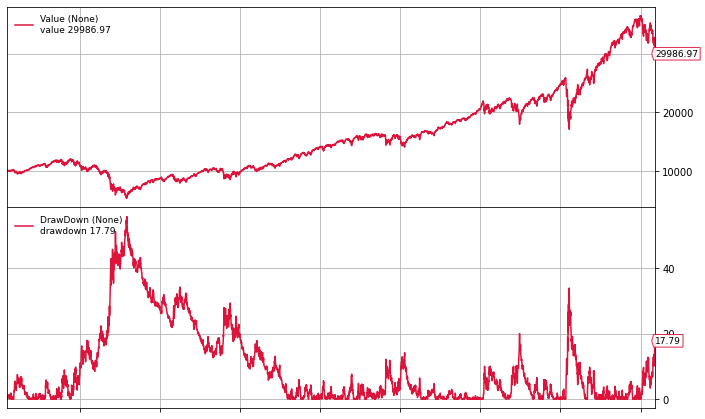

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
plt.plot() 

start = 300
end = prices.shape[0] - 1

dd, cagr, sharpe = backtest([benchmark],
                            BuyAndHold,
                            start=start,
                            end=end,
                            plot=True)

In [7]:
############################################################
# Show Buy and Hold Strategy Stats 
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 55.68%
CAGR: 6.68%
Sharpe: 0.467


In [8]:
stat=pd.DataFrame([dd,cagr,sharpe])

# 2. Mean variance optimization

In [9]:
############################################################
# Calculate assets returns
############################################################

data = prices.loc[:, ('Adj Close', slice(None))]
data.columns = assets
returns = data.pct_change().dropna()
display(returns.head())

,EEM,EPP,GLD,IWM,LQD,SHY,SPY,TIP,TLT,VTI
Date,,,,,,,,,,
2005-01-03,-0.010404,-0.009427,-0.017808,-0.012973,0.006455,0.000124,-0.004716,-0.000283,0.002145,-0.007201
2005-01-04,-0.030789,-0.020152,-0.006509,-0.021437,-0.005612,-0.002211,-0.012220,-0.006902,-0.010480,-0.013310
2005-01-05,-0.012241,-0.002857,-0.001638,-0.019987,0.000807,0.000246,-0.006901,-0.001143,0.005353,-0.006918
2005-01-06,-0.000680,0.002407,-0.012186,0.005303,0.000715,0.000491,0.005085,0.001621,0.000679,0.004789
2005-01-07,0.001936,-0.003658,-0.007355,-0.011118,-0.000447,0.000123,-0.001434,-0.002570,0.002264,-0.003206


In [10]:
############################################################
# Selecting Dates for Rebalancing
############################################################

# Selecting last day of month of available data
index = returns.groupby([returns.index.year, returns.index.month]).tail(1).index
index_2 = returns.index

# Quarterly Dates
index = [x for x in index if float(x.month) % 3.0 == 0 ] 

# Dates where the strategy will be backtested
index_ = [index_2.get_loc(x) for x in index if index_2.get_loc(x) > 300]

In [11]:
############################################################
# Building the Asset Allocation Class
############################################################

class AssetAllocation(bt.Strategy):

    def __init__(self):

        j = 0
        for i in assets:
            setattr(self, i, self.datas[j])
            j += 1
        
        self.counter = 0
        
    def next(self):
        if self.counter in weights.index.tolist():
            for i in assets:
                w = weights.loc[self.counter, i]
                self.order_target_percent(getattr(self, i), target=w)
        self.counter += 1

In [12]:
method_mu='hist' 
method_cov='ledoit'
rm = 'MV' 
obj = 'Sharpe' 
hist = True 
rf = 0 # Risk free rate

weights = pd.DataFrame([])
    
for i in index_:
        Y = returns.iloc[:i,:] 

        port = rp.Portfolio(returns=Y)
        


        port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

        port.solvers = ['MOSEK']
        port.alpha = 0.05
        model='Classic' 
        
        w = port.optimization(model=model, rm=rm, obj=obj, rf=rf,hist=hist)

        if w is None:
            w = weights.tail(1).T
        weights = pd.concat([weights, w.T], axis = 0)

weights.index=index_

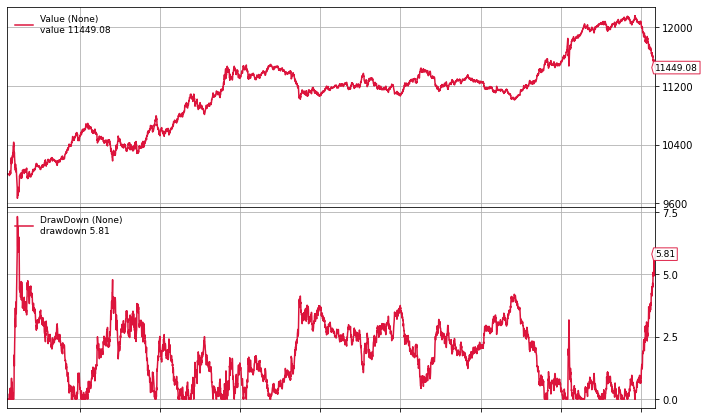

In [13]:
end = returns.shape[0]-1
dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [14]:
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")
stat=pd.concat([stat,pd.DataFrame([dd,cagr,sharpe])],axis=1)

Max Drawdown: 7.32%
CAGR: 0.79%
Sharpe: 0.310


array([<AxesSubplot:ylabel='4341'>], dtype=object)

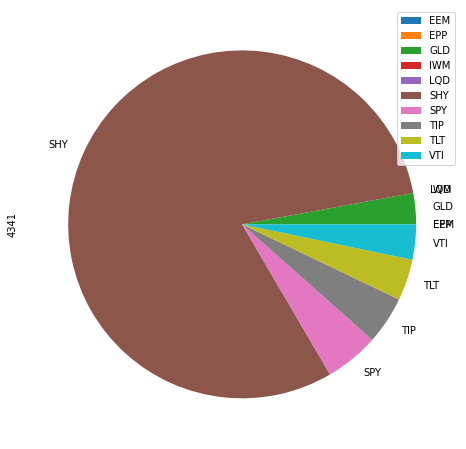

In [15]:
w = pd.DataFrame(weights.iloc[-1,:])
w.plot.pie(subplots=True, figsize=(8, 8))

# 3.0 B&L with random views

In [16]:
############################################################
# generate 10 random views and allocations with B&L model
# this section could take some time to run
############################################################


trial = {}
for j in range(0,10):
    weights = pd.DataFrame([])

    for i in index_:
            Y = returns.iloc[:i,:] 

            # Building the portfolio object
            port = rp.Portfolio(returns=Y)

            asset_classes = pd.DataFrame(assets)
            asset_classes.columns = ['Assets']
            signs=['>=','<=']
            mm=0.3

            views = {'Disabled': [False]*int(len(assets)*mm),
                     'Type': ['Assets']*int(len(assets)*mm),
                     'Set': ['']*int(len(assets)*mm),
                     'Position': list(np.random.choice(assets,int(len(assets)*mm))),
                     'Sign': list(np.random.choice(signs,int(len(assets)*mm))),
                     'Weight': list(np.random.choice(range(-5,5),int(len(assets)*mm))/100), # Anual terms 
                     'Type Relative': ['Assets']*int(len(assets)*mm),
                     'Relative Set': ['']*int(len(assets)*mm)}
            views.update({
                     'Relative': list(np.random.choice([x for x in assets if x not in list(views['Position'])],int(len(assets)*mm)))})
            views = pd.DataFrame(views)
            P, Q = rp.assets_views(views, asset_classes)

            port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
            # Select method and estimate input parameters:
            port.blacklitterman_stats(P, Q/252, rf=rf, w=w, delta=None, eq=True)
            port.solvers = ['MOSEK']
            model='BL'# Black Litterman

            w = port.optimization(model=model, rm=rm, obj=obj, rf=rf)

            if w is None:
                w = weights.tail(1).T
            weights = pd.concat([weights, w.T], axis = 0)
    trial[j] = weights.copy()
    trial[j].index = index_

The problem doesn't have a solution with actual input parameters


In [17]:
for i in range(0,9):
    weights = trial[i]
    dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=False)
    if i==0:
        rs=pd.DataFrame([dd,cagr, sharpe])
    else:
        rs=pd.concat([rs,pd.DataFrame([dd,cagr, sharpe])],axis=1)
rs=rs.T
rs.columns=['0','1','2']

In [18]:
pd.options.display.float_format = '{:,}'.format
rs.describe()

,0,1,2
count,9.0,9.0,9.0
mean,16.62773503446526,2.3373494457876816,0.3479100283609556
std,3.4958570335223547,0.35187020559469967,0.06774799753603068
min,13.493878978101009,1.7733172639685022,0.2479868794067562
25%,14.830654732601495,2.130846471192724,0.30615773721352596
50%,15.155630331883948,2.2783497258726917,0.3283769469278727
75%,17.348817873730148,2.685452661380655,0.4048695013584953
max,25.0535662799082,2.800509037917378,0.44362467192521843


In [19]:
stat=pd.concat([stat,pd.DataFrame(rs.mean()).set_index(stat.index)],axis=1)

# NCO by Lopez de Prado

In [20]:
codependence = 'pearson' # Correlation matrix used to group assets in clusters
covariance = 'spectral' # Covariance estimation technique
linkage = 'ward' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic
leaf_order = True # Consider optimal order of leafs in dendrogram

weights = pd.DataFrame([])
    
for i in index_:
        Y = returns.iloc[:i,:] 

        port = rp.HCPortfolio(returns=Y)

        port.solvers = ['MOSEK']
        model='NCO' # Could be HRP or HERC
        obj = "ERC" # Posible values are "MinRisk", "Utility", "Sharpe" and "ERC"

        w = port.optimization(model=model,
                              codependence=codependence,
                              covariance=covariance,
                              obj=obj,
                              rm='MV',
                              rf=rf,
                              linkage=linkage,
                              max_k=max_k,
                              leaf_order=leaf_order)

        if w is None:
            w = weights.tail(1).T
        weights = pd.concat([weights, w.T], axis = 0)

weights.index=index_

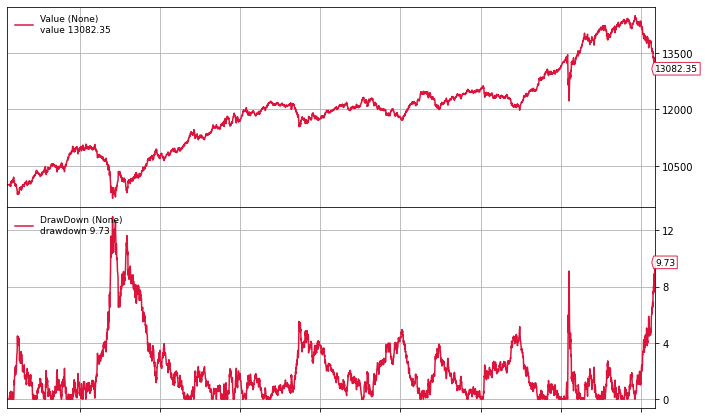

In [21]:
dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [22]:
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")
stat=pd.concat([stat,pd.DataFrame([dd,cagr,sharpe])],axis=1)

Max Drawdown: 12.99%
CAGR: 1.57%
Sharpe: 0.348


array([<AxesSubplot:ylabel='4341'>], dtype=object)

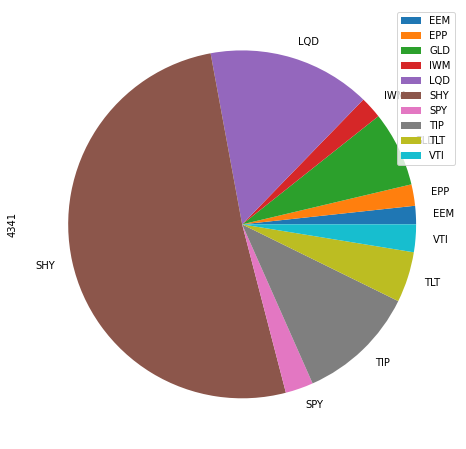

In [23]:
w = pd.DataFrame(weights.iloc[-1,:])
w.plot.pie(subplots=True, figsize=(8, 8))

# HERC w/equally weights within clusters

In [24]:
weights = pd.DataFrame([])
    
for i in index_:
        Y = returns.iloc[:i,:] 
        port = rp.HCPortfolio(returns=Y)

        model='HERC2' 

        w = port.optimization(model=model,
                              codependence=codependence,
                              covariance='shrink',
                              rm='MV',
                              obj='ERC',
                              
                              rf=rf,
                              linkage=linkage,
                              max_k=max_k,
                              leaf_order=leaf_order)

        if w is None:
            w = weights.tail(1).T
        weights = pd.concat([weights, w.T], axis = 0)

weights.index=index_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

array([<AxesSubplot:ylabel='EEM'>, <AxesSubplot:ylabel='EPP'>,
       <AxesSubplot:ylabel='GLD'>, <AxesSubplot:ylabel='IWM'>,
       <AxesSubplot:ylabel='IXC'>, <AxesSubplot:ylabel='LQD'>,
       <AxesSubplot:ylabel='SHY'>, <AxesSubplot:ylabel='SPY'>,
       <AxesSubplot:ylabel='TIP'>, <AxesSubplot:ylabel='TLT'>,
       <AxesSubplot:ylabel='VTI'>], dtype=object)

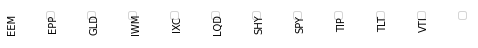

In [55]:
w = pd.DataFrame(weights.iloc[-1,:])
w.plot.pie(subplots=True, figsize=(8, 8))

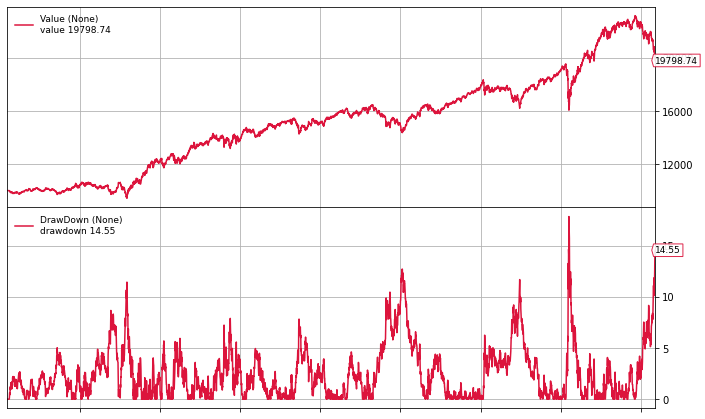

In [26]:
dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [27]:
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")
stat=pd.concat([stat,pd.DataFrame([dd,cagr,sharpe])],axis=1)

Max Drawdown: 17.84%
CAGR: 4.07%
Sharpe: 0.550


# Naive HERC

array([<AxesSubplot:ylabel='4341'>], dtype=object)

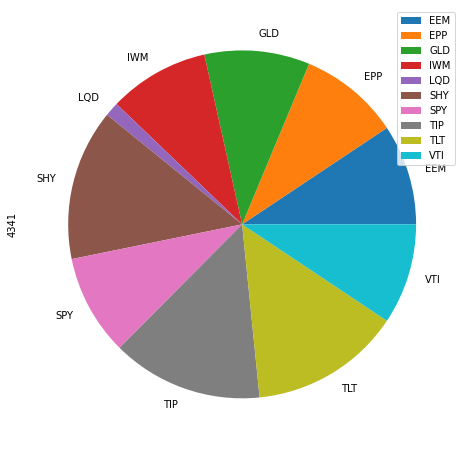

In [28]:
weights = pd.DataFrame([])
    
for i in index_:
        Y = returns.iloc[:i,:] 

        port = rp.HCPortfolio(returns=Y)

        model='HERC2' 
        obj = "ERC"

        w = port.optimization(model=model,
                              codependence=codependence,
                              covariance='hist',
                              obj=obj,
                              rm='MV',
                              rf=rf,
                              linkage=linkage,
                              max_k=max_k,
                              leaf_order=leaf_order)

        if w is None:
            w = weights.tail(1).T
        weights = pd.concat([weights, w.T], axis = 0)

weights.index=index_
w = pd.DataFrame(weights.iloc[-1,:])
w.plot.pie(subplots=True, figsize=(8, 8))

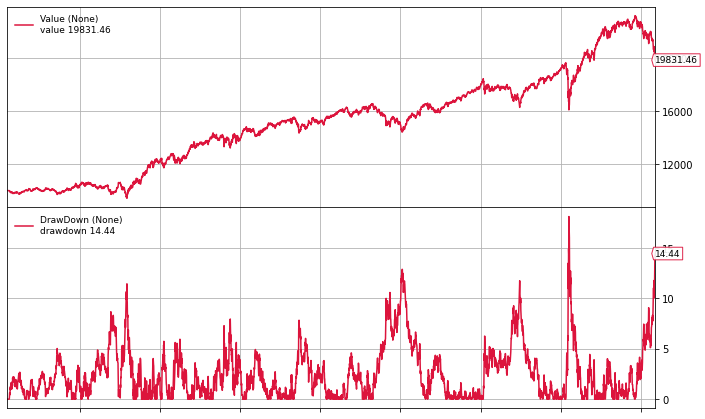

In [29]:
dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)


In [30]:
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")
stat=pd.concat([stat,pd.DataFrame([dd,cagr,sharpe])],axis=1)

Max Drawdown: 18.11%
CAGR: 4.08%
Sharpe: 0.550


# HRP

In [31]:
weights = pd.DataFrame([])
    
for i in index_:
        Y = returns.iloc[:i,:] 
        port = rp.HCPortfolio(returns=Y)

        model='HRP' 
        obj = "ERC" 

        w = port.optimization(model=model,
                              codependence=codependence,
                              covariance=covariance,
                              obj=obj,
                              rm='VaR',
                              rf=rf,
                              linkage=linkage,
                              max_k=max_k,
                              leaf_order=leaf_order)

        if w is None:
            w = weights.tail(1).T
        weights = pd.concat([weights, w.T], axis = 0)

weights.index=index_

array([<AxesSubplot:ylabel='4341'>], dtype=object)

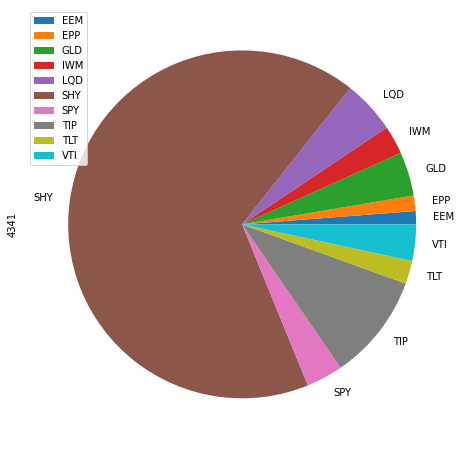

In [32]:
w = pd.DataFrame(weights.iloc[-1,:])
w.plot.pie(subplots=True, figsize=(8, 8))

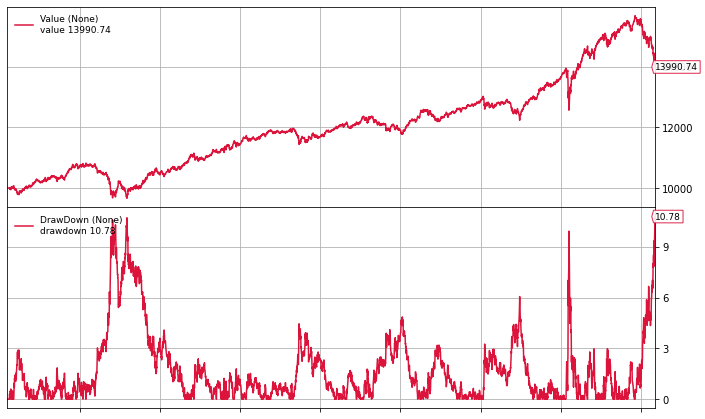

In [33]:
dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [34]:
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")
stat=pd.concat([stat,pd.DataFrame([dd,cagr,sharpe])],axis=1)

Max Drawdown: 10.85%
CAGR: 1.98%
Sharpe: 0.416


# All Weather - Lazy Portfolio

In [35]:
weights=pd.read_excel('W.xlsx') ## load a lazy portfolio allocation based on the book "All Weather Portfolio Strategy Portfolio" - Ray Dalio (2019)

array([<AxesSubplot:ylabel='0'>], dtype=object)

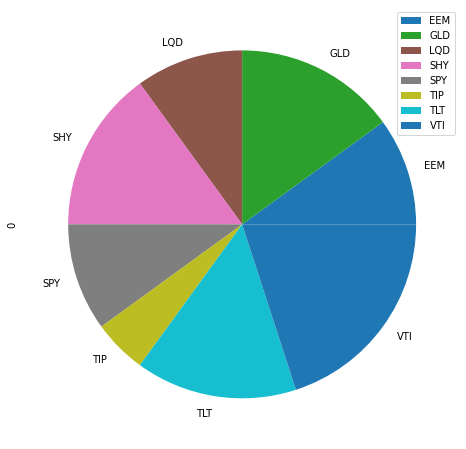

In [36]:
weights.T.plot.pie(subplots=True, figsize=(8, 8))

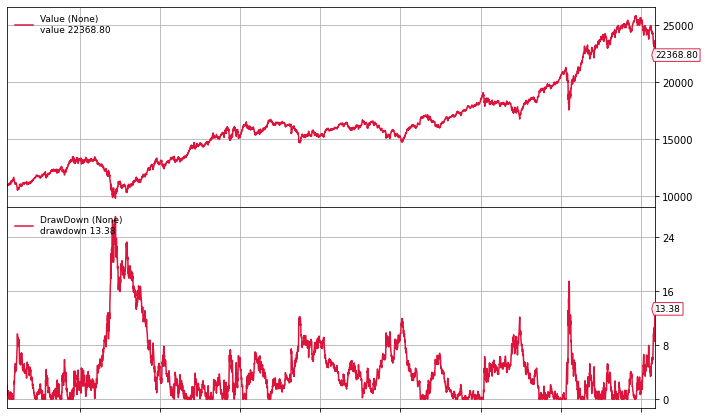

In [37]:
dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [38]:
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")
stat=pd.concat([stat,pd.DataFrame([dd,cagr,sharpe])],axis=1)

Max Drawdown: 27.06%
CAGR: 4.78%
Sharpe: 0.505


# Results

In [39]:
stat.columns=['S&P 500','MV','BL','NCO','HERC2','HERC','HRP','AW'] ## delete the model(s) if you have disabled before some
stat=stat.T
stat.columns= ['Max. Drawdown','CAGR','Sharpe']
stat.sort_values('Sharpe',ascending=False)

,Max. Drawdown,CAGR,Sharpe
HERC,18.10787903683261,4.0776332344754245,0.5503554970501054
HERC2,17.839435691730987,4.068699699405743,0.5499867563428011
AW,27.06417426515756,4.78031174185119,0.5051272306349077
S&P 500,55.68178695783098,6.677267013678528,0.46695628188622157
HRP,10.846489728828734,1.9847884840318912,0.4158300428332845
BL,16.62773503446526,2.3373494457876816,0.3479100283609556
NCO,12.988513493661756,1.5705479779413087,0.3477266544744901
MV,7.322266225845084,0.7917394725375806,0.3099102654823596


In [40]:
['black']*5+['yellow']

['black', 'black', 'black', 'black', 'black', 'yellow']

<AxesSubplot:title={'center':'Sharpe ratios for different models'}>

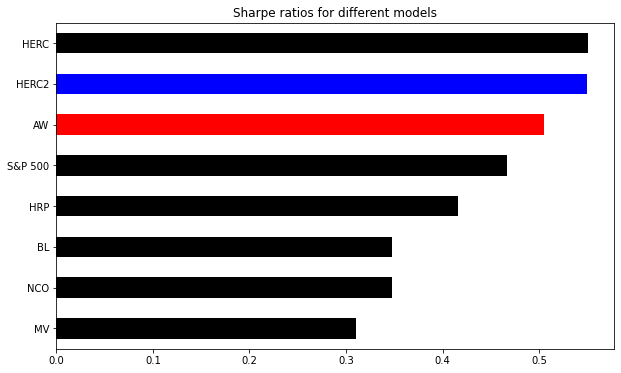

In [41]:
stat.iloc[:]['Sharpe'].sort_values().plot.barh(title='Sharpe ratios for different models', color=['black']*5+['red','blue']+['black'])

<AxesSubplot:title={'center':'Max. DD for different models'}>

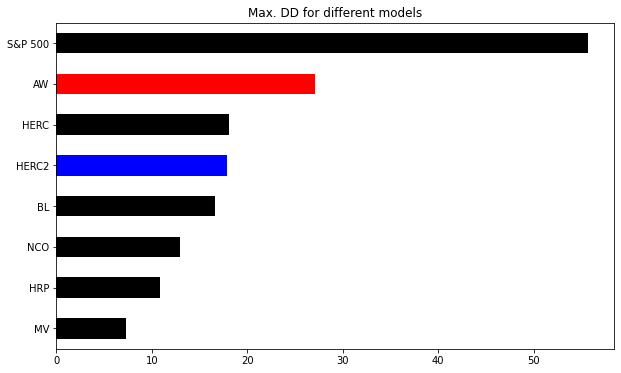

In [49]:
stat.iloc[:]['Max. Drawdown'].sort_values().plot.barh(title='Max. DD for different models', color=['black']*4+['blue','black','red','black'])

<AxesSubplot:title={'center':'Cagr/Max. Drawdown'}>

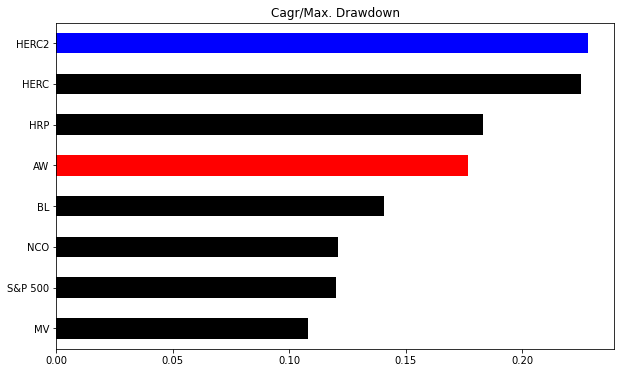

In [52]:
(stat.iloc[:]['CAGR']/stat.iloc[:]['Max. Drawdown']).sort_values().plot.barh(title='Cagr/Max. Drawdown',color=['black']*4+['red','black','black','blue'])

<AxesSubplot:title={'center':'CAGR for different models'}>

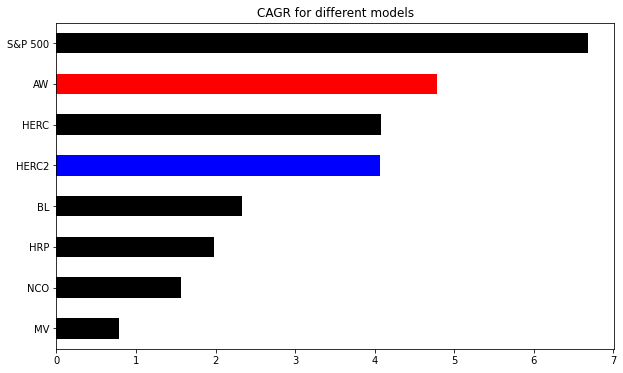

In [51]:
stat.iloc[:]['CAGR'].sort_values().plot.barh(title='CAGR for different models',color=['black']*4+['blue']+['black']+['red'])

# Conclusions

Strong assumptions influencing the results:
* Dataset chosen
* Frequency chosen
* Risk-free rate assumed to be =0%
* All Weather portfolio is not unique
